<a href="https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/CLIP_Guided_Stable_diffusion_with_diffusers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CLIP Guided Stable Diffusion using [d🧨ffusers](https://github.com/huggingface/diffusers)

This notebook shows how to do CLIP guidance with Stable diffusion using diffusers libray. This allows you to use newly released [CLIP models by LAION AI.](https://huggingface.co/laion).

This notebook is based on the following amazing repos, all credits to the original authors!

- https://github.com/Jack000/glid-3-xl
- https://github.dev/crowsonkb/k-diffusion


### Initial Setup

In [1]:
#@title Instal dependancies
!pip install -qqq diffusers transformers ftfy

     |████████████████████████████████| 153 kB 9.4 MB/s 
     |████████████████████████████████| 4.9 MB 84.0 MB/s 
     |████████████████████████████████| 120 kB 92.3 MB/s 
     |████████████████████████████████| 6.6 MB 76.8 MB/s 


#### Authenticate with Hugging Face Hub

You have to be a registered user in 🤗 Hugging Face Hub, and you'll also need to use an access token for the code to work. For more information on access tokens, please refer to [this section of the documentation](https://huggingface.co/docs/hub/security-tokens).

In [ ]:
#@title Login
from huggingface_hub import notebook_login

notebook_login()

### CLIP Guided Stable Diffusion

In [1]:
#@title Define the pipeline

import inspect
from typing import List, Optional, Union

import torch
from torch import nn
from torch.nn import functional as F

from diffusers import AutoencoderKL, DiffusionPipeline, LMSDiscreteScheduler, PNDMScheduler, UNet2DConditionModel
from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion import StableDiffusionPipelineOutput
from torchvision import transforms
from transformers import CLIPFeatureExtractor, CLIPModel, CLIPTextModel, CLIPTokenizer


class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cut_power=1.0):
        super().__init__()

        self.cut_size = cut_size
        self.cut_power = cut_power

    def forward(self, pixel_values, num_cutouts):
        sideY, sideX = pixel_values.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        for _ in range(num_cutouts):
            size = int(torch.rand([]) ** self.cut_power * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = pixel_values[:, :, offsety : offsety + size, offsetx : offsetx + size]
            cutouts.append(F.adaptive_avg_pool2d(cutout, self.cut_size))
        return torch.cat(cutouts)


def spherical_dist_loss(x, y):
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    return (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2)


def set_requires_grad(model, value):
    for param in model.parameters():
        param.requires_grad = value


class CLIPGuidedStableDiffusion(DiffusionPipeline):
    """CLIP guided stable diffusion based on the amazing repo by @crowsonkb and @Jack000
    - https://github.com/Jack000/glid-3-xl
    - https://github.dev/crowsonkb/k-diffusion
    """

    def __init__(
        self,
        vae: AutoencoderKL,
        text_encoder: CLIPTextModel,
        clip_model: CLIPModel,
        tokenizer: CLIPTokenizer,
        unet: UNet2DConditionModel,
        scheduler: Union[PNDMScheduler, LMSDiscreteScheduler],
        feature_extractor: CLIPFeatureExtractor,
    ):
        super().__init__()
        scheduler = scheduler.set_format("pt")
        self.register_modules(
            vae=vae,
            text_encoder=text_encoder,
            clip_model=clip_model,
            tokenizer=tokenizer,
            unet=unet,
            scheduler=scheduler,
            feature_extractor=feature_extractor,
        )

        self.normalize = transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
        self.make_cutouts = MakeCutouts(feature_extractor.size)

        set_requires_grad(self.text_encoder, False)
        set_requires_grad(self.clip_model, False)

    def enable_attention_slicing(self, slice_size: Optional[Union[str, int]] = "auto"):
        if slice_size == "auto":
            # half the attention head size is usually a good trade-off between
            # speed and memory
            slice_size = self.unet.config.attention_head_dim // 2
        self.unet.set_attention_slice(slice_size)

    def disable_attention_slicing(self):
        self.enable_attention_slicing(None)

    def freeze_vae(self):
        set_requires_grad(self.vae, False)

    def unfreeze_vae(self):
        set_requires_grad(self.vae, True)

    def freeze_unet(self):
        set_requires_grad(self.unet, False)

    def unfreeze_unet(self):
        set_requires_grad(self.unet, True)

    @torch.enable_grad()
    def cond_fn(
        self,
        latents,
        timestep,
        index,
        text_embeddings,
        noise_pred_original,
        text_embeddings_clip,
        clip_guidance_scale,
        num_cutouts,
        use_cutouts=True,
    ):
        latents = latents.detach().requires_grad_()

        if isinstance(self.scheduler, LMSDiscreteScheduler):
            sigma = self.scheduler.sigmas[index]
            # the model input needs to be scaled to match the continuous ODE formulation in K-LMS
            latent_model_input = latents / ((sigma**2 + 1) ** 0.5)
        else:
            latent_model_input = latents

        # predict the noise residual
        noise_pred = self.unet(latent_model_input, timestep, encoder_hidden_states=text_embeddings).sample

        if isinstance(self.scheduler, PNDMScheduler):
            alpha_prod_t = self.scheduler.alphas_cumprod[timestep]
            beta_prod_t = 1 - alpha_prod_t
            # compute predicted original sample from predicted noise also called
            # "predicted x_0" of formula (12) from https://arxiv.org/pdf/2010.02502.pdf
            pred_original_sample = (latents - beta_prod_t ** (0.5) * noise_pred) / alpha_prod_t ** (0.5)

            fac = torch.sqrt(beta_prod_t)
            sample = pred_original_sample * (fac) + latents * (1 - fac)
        elif isinstance(self.scheduler, LMSDiscreteScheduler):
            sigma = self.scheduler.sigmas[index]
            sample = latents - sigma * noise_pred
        else:
            raise ValueError(f"scheduler type {type(self.scheduler)} not supported")

        sample = 1 / 0.18215 * sample
        image = self.vae.decode(sample).sample
        image = (image / 2 + 0.5).clamp(0, 1)

        if use_cutouts:
            image = self.make_cutouts(image, num_cutouts)
        else:
            image = transforms.Resize(self.feature_extractor.size)(image)
        image = self.normalize(image)

        image_embeddings_clip = self.clip_model.get_image_features(image).float()
        image_embeddings_clip = image_embeddings_clip / image_embeddings_clip.norm(p=2, dim=-1, keepdim=True)

        if use_cutouts:
            dists = spherical_dist_loss(image_embeddings_clip, text_embeddings_clip)
            dists = dists.view([num_cutouts, sample.shape[0], -1])
            loss = dists.sum(2).mean(0).sum() * clip_guidance_scale
        else:
            loss = spherical_dist_loss(image_embeddings_clip, text_embeddings_clip).mean() * clip_guidance_scale

        grads = -torch.autograd.grad(loss, latents)[0]

        if isinstance(self.scheduler, LMSDiscreteScheduler):
            latents = latents.detach() + grads * (sigma**2)
        else:
            noise_pred = noise_pred - torch.sqrt(beta_prod_t) * grads
        return noise_pred_original, latents

    @torch.no_grad()
    def __call__(
        self,
        prompt: Union[str, List[str]],
        height: Optional[int] = 512,
        width: Optional[int] = 512,
        num_inference_steps: Optional[int] = 50,
        guidance_scale: Optional[float] = 7.5,
        clip_guidance_scale: Optional[float] = 100,
        clip_prompt: Optional[Union[str, List[str]]] = None,
        num_cutouts: Optional[int] = 4,
        use_cutouts: Optional[bool] = True,
        generator: Optional[torch.Generator] = None,
        latents: Optional[torch.FloatTensor] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
    ):
        if isinstance(prompt, str):
            batch_size = 1
        elif isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            raise ValueError(f"`prompt` has to be of type `str` or `list` but is {type(prompt)}")

        if height % 8 != 0 or width % 8 != 0:
            raise ValueError(f"`height` and `width` have to be divisible by 8 but are {height} and {width}.")

        # get prompt text embeddings
        text_input = self.tokenizer(
            prompt,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        text_embeddings = self.text_encoder(text_input.input_ids.to(self.device))[0]

        if clip_guidance_scale > 0:
            if clip_prompt is not None:
                clip_text_input = self.tokenizer(
                    clip_prompt,
                    padding="max_length",
                    max_length=self.tokenizer.model_max_length,
                    truncation=True,
                    return_tensors="pt",
                ).to(self.device)
            else:
                clip_text_input = text_input.input_ids.to(self.device)
            text_embeddings_clip = self.clip_model.get_text_features(clip_text_input)
            text_embeddings_clip = text_embeddings_clip / text_embeddings_clip.norm(p=2, dim=-1, keepdim=True)

        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0
        # get unconditional embeddings for classifier free guidance
        if do_classifier_free_guidance:
            max_length = text_input.input_ids.shape[-1]
            uncond_input = self.tokenizer(
                [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
            )
            uncond_embeddings = self.text_encoder(uncond_input.input_ids.to(self.device))[0]

            # For classifier free guidance, we need to do two forward passes.
            # Here we concatenate the unconditional and text embeddings into a single batch
            # to avoid doing two forward passes
            text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

        # get the initial random noise unless the user supplied it

        # Unlike in other pipelines, latents need to be generated in the target device
        # for 1-to-1 results reproducibility with the CompVis implementation.
        # However this currently doesn't work in `mps`.
        latents_device = "cpu" if self.device.type == "mps" else self.device
        latents_shape = (batch_size, self.unet.in_channels, height // 8, width // 8)
        if latents is None:
            latents = torch.randn(
                latents_shape,
                generator=generator,
                device=latents_device,
            )
        else:
            if latents.shape != latents_shape:
                raise ValueError(f"Unexpected latents shape, got {latents.shape}, expected {latents_shape}")
        latents = latents.to(self.device)

        # set timesteps
        accepts_offset = "offset" in set(inspect.signature(self.scheduler.set_timesteps).parameters.keys())
        extra_set_kwargs = {}
        if accepts_offset:
            extra_set_kwargs["offset"] = 1

        self.scheduler.set_timesteps(num_inference_steps, **extra_set_kwargs)

        # if we use LMSDiscreteScheduler, let's make sure latents are multiplied by sigmas
        if isinstance(self.scheduler, LMSDiscreteScheduler):
            latents = latents * self.scheduler.sigmas[0]

        for i, t in enumerate(self.progress_bar(self.scheduler.timesteps)):
            # expand the latents if we are doing classifier free guidance
            latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
            if isinstance(self.scheduler, LMSDiscreteScheduler):
                sigma = self.scheduler.sigmas[i]
                # the model input needs to be scaled to match the continuous ODE formulation in K-LMS
                latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

            # # predict the noise residual
            noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

            # perform classifier free guidance
            if do_classifier_free_guidance:
                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # perform clip guidance
            if clip_guidance_scale > 0:
                text_embeddings_for_guidance = (
                    text_embeddings.chunk(2)[0] if do_classifier_free_guidance else text_embeddings
                )
                noise_pred, latents = self.cond_fn(
                    latents,
                    t,
                    i,
                    text_embeddings_for_guidance,
                    noise_pred,
                    text_embeddings_clip,
                    clip_guidance_scale,
                    num_cutouts,
                    use_cutouts,
                )

            # compute the previous noisy sample x_t -> x_t-1
            if isinstance(self.scheduler, LMSDiscreteScheduler):
                latents = self.scheduler.step(noise_pred, i, latents).prev_sample
            else:
                latents = self.scheduler.step(noise_pred, t, latents).prev_sample

        # scale and decode the image latents with vae
        latents = 1 / 0.18215 * latents
        image = self.vae.decode(latents).sample

        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.cpu().permute(0, 2, 3, 1).numpy()

        if output_type == "pil":
            image = self.numpy_to_pil(image)

        if not return_dict:
            return (image, None)

        return StableDiffusionPipelineOutput(images=image, nsfw_content_detected=None)


In [2]:
#@title Load the pipeline
import torch
from diffusers import LMSDiscreteScheduler, StableDiffusionPipeline
from PIL import Image
from transformers import CLIPFeatureExtractor, CLIPModel

model_id = "CompVis/stable-diffusion-v1-4" #@param {type: "string"}
clip_model_id = "laion/CLIP-ViT-B-32-laion2B-s34B-b79K" #@param {type: "string"}
scheduler = "plms" #@param ['plms', 'lms']


def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

def create_clip_guided_pipeline(
    model_id="CompVis/stable-diffusion-v1-4", clip_model_id="laion/CLIP-ViT-B-32-laion2B-s34B-b79K", scheduler="plms"
):
    pipeline = StableDiffusionPipeline.from_pretrained(
        model_id,
        torch_dtype=torch.float16,
        revision="fp16",
        use_auth_token=True,
    )

    if scheduler == "lms":
        scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear")
    else:
        scheduler = pipeline.scheduler

    clip_model = CLIPModel.from_pretrained(clip_model_id, torch_dtype=torch.float16)
    feature_extractor = CLIPFeatureExtractor.from_pretrained(clip_model_id, torch_dtype=torch.float16)

    guided_pipeline = CLIPGuidedStableDiffusion(
        unet=pipeline.unet,
        vae=pipeline.vae,
        tokenizer=pipeline.tokenizer,
        text_encoder=pipeline.text_encoder,
        scheduler=scheduler,
        clip_model=clip_model,
        feature_extractor=feature_extractor,
    )

    return guided_pipeline

guided_pipeline = create_clip_guided_pipeline(model_id, clip_model_id)
guided_pipeline = guided_pipeline.to("cuda")

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.
{'trained_betas'} was not found in config. Values will be initialized to default values.


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

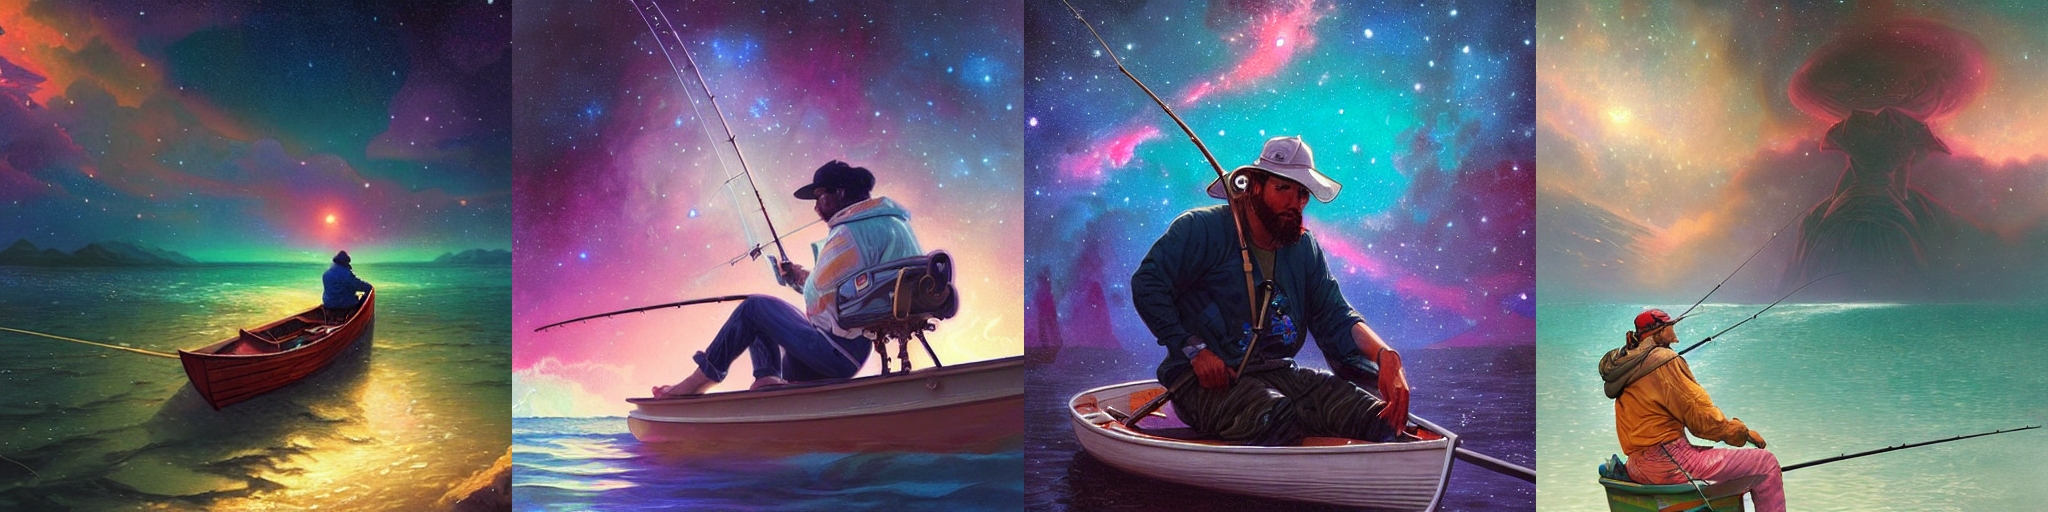

In [3]:
#@title Generate

prompt = "a fisherman, sitting in a boat amidst a large galaxy nebula, fishing pole, vaporwave aesthetic, colorful, psychedelic, digital painting, artstation, concept art, smooth, sharp focus, illustration, art by artgerm and greg rutkowski and alphonse mucha" #@param {type: "string"}
clip_prompt = "" #@param {type: "string"}
num_samples = 4 #@param {type: "number"}
num_inference_steps = 50 #@param {type: "number"}
guidance_scale = 7.5 #@param {type: "number"}
clip_guidance_scale = 100 #@param {type: "number"}
num_cutouts = 4 #@param {type: "number"}
use_cutouts = "True" #@param ["False", "True"]
unfreeze_unet = "False" #@param ["False", "True"]
unfreeze_vae = "True" #@param ["False", "True"]

if unfreeze_unet == "True":
  guided_pipeline.unfreeze_unet()
else:
  guided_pipeline.freeze_unet()

if unfreeze_vae == "True":
  guided_pipeline.unfreeze_vae()
else:
  guided_pipeline.freeze_vae()

images = []
for i in range(num_samples):
    with torch.autocast("cuda"):
        image = guided_pipeline(
            prompt,
            clip_prompt=clip_prompt if clip_prompt.strip() != "" else None,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale, 
            clip_guidance_scale=clip_guidance_scale,
            num_cutouts=num_cutouts,
            use_cutouts=use_cutouts == "True"
        ).images[0]
    images.append(image)

image_grid(images, 1, num_samples)